The third edition of *Think Stats* is available now from [Bookshop.org](https://bookshop.org/a/98697/9781098190255) and [Amazon](https://amzn.to/42lmxwu) (those are affiliate links). If you are enjoying the free, online version, consider [buying me a coffee](https://buymeacoffee.com/allendowney).

# Cumulative Distribution Functions

Frequency tables and PMFs are the most familiar ways to represent distributions, but as we'll see in this chapter, they have limitations.
An alternative is the cumulative distribution function (CDF), which is useful for computing percentiles, and especially useful for comparing distributions.

Also in this chapter, we'll compute percentile-based statistics to quantify the location, spread, and skewness of a distribution.

[Click here to run this notebook on Colab](https://colab.research.google.com/github/AllenDowney/ThinkStats/blob/v3/nb/chap04.ipynb).

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

Downloaded thinkstats.py


In [2]:
try:
    import empiricaldist
except ImportError:
    %pip install empiricaldist

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for empiricaldist: filename=empiricaldist-0.9.0-py3-none-any.whl size=14296 sha256=014c50bc0ccb7be303c927f744ace300b61b530cf1db8bafbaeedd7524f6a9eb
  Stored in directory: /root/.cache/pip/wheels/96/04/f1/a934ef1f5f3db621dc39566b2c7de45b8c6916044be6a9c9ac
Successfully built empiricaldist


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

## Percentiles and Percentile Ranks

If you have taken a standardized test, you probably got your results in the form of a raw score and a **percentile rank**.
In this context, the percentile rank is the percentage of people who got the same score as you or lower.
So if you are "in the 90th percentile," you did as well as or better than 90% of the people who took the exam.

To understand percentiles and percentile ranks, let's consider an example based on running speeds.
Some years ago I ran the James Joyce Ramble, which is a 10 kilometer road race in Massachusetts.
After the race, I downloaded the results to see how my time compared to other runners.

Instructions for downloading the data are in the notebook for this chapter.

In [4]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/relay.py")
download(
    "https://github.com/AllenDowney/ThinkStats/raw/v3/data/Apr25_27thAn_set1.shtml"
)

Downloaded relay.py
Downloaded Apr25_27thAn_set1.shtml


The `relay.py` module provides a function that reads the results and returns a Pandas `DataFrame`.

In [5]:
from relay import read_results

results = read_results()
results.head()

,Place,Div/Tot,Division,Guntime,Nettime,Min/Mile,MPH
0,1,1/362,M2039,30:43,30:42,4:57,12.121212
1,2,2/362,M2039,31:36,31:36,5:06,11.764706
2,3,3/362,M2039,31:42,31:42,5:07,11.726384
3,4,4/362,M2039,32:28,32:27,5:14,11.464968
4,5,5/362,M2039,32:52,32:52,5:18,11.320755


`results` contains one row for each of 1633 runners who finished the race.
The column we'll use to quantify performance is `MPH`, which contains each runner's average speed in miles per hour.
We'll select this column and use `values` to extract the speeds as a NumPy array.

In [6]:
speeds = results["MPH"].values

I finished in 42:44, so we can find my row like this.

In [7]:
my_result = results.query("Nettime == '42:44'")
my_result

,Place,Div/Tot,Division,Guntime,Nettime,Min/Mile,MPH
96,97,26/256,M4049,42:48,42:44,6:53,8.716707


The index of my row is 96, so we can extract my speed like this.

In [8]:
my_speed = speeds[96]

We can use `sum` to count the number of runners at my speed or slower.

In [9]:
(speeds <= my_speed).sum()

np.int64(1537)

And we can use `mean` to compute the percentage of runners at my speed or slower.

In [10]:
(speeds <= my_speed).mean() * 100

np.float64(94.12124923453766)

The result is my percentile rank in the field, which was about 94%.

More generally, the following function computes the percentile rank of a particular value in a sequence of values.

In [11]:
def percentile_rank(x, seq):
    """Percentile rank of x.

    x: value
    seq: sequence of values

    returns: percentile rank 0-100
    """
    return (seq <= x).mean() * 100

In `results`, the `Division` column indicates the division each runner was in, identified by gender and age range -- for example, I was in the M4049 division, which includes male runners aged 40 to 49.
We can use the `query` method to select the rows for people in my division and extract their speeds.

In [100]:
my_division = results.query("Division == 'M4049'")
my_division_speeds = my_division["MPH"].values


Now we can use `percentile_rank` to compute my percentile rank in my division.

In [13]:
percentile_rank(my_speed, my_division_speeds)

np.float64(90.234375)

Going in the other direction, if we are given a percentile rank, the following function finds the corresponding value in a sequence.

In [14]:
def percentile(p, seq):
    n = len(seq)
    i = (1 - p / 100) * (n + 1)
    return seq[round(i)]

`n` is the number of elements in the sequence; `i` is the index of the element with the given percentile rank.
When we look up a percentile rank, the corresponding value is called a **percentile**.

In [15]:
percentile(90, my_division_speeds)

np.float64(8.591885441527447)

In my division, the 90th percentile was about 8.6 mph.

Now, some years after I ran that race, I am in the `M5059` division.
So let's see how fast I would have to run to have the same percentile rank in my new division.
We can answer that question by converting my percentile rank in the `M4049` division, which is about 90.2%, to a speed in the `M5059` division.

In [16]:
next_division = results.query("Division == 'M5059'")
next_division_speeds = next_division["MPH"].values

percentile(90.2, next_division_speeds)

np.float64(8.017817371937639)

The person in the `M5059` division with the same percentile rank as me ran just over 8 mph.
We can use `query` to find him.

In [17]:
next_division.query("MPH > 8.01").tail(1)

,Place,Div/Tot,Division,Guntime,Nettime,Min/Mile,MPH
222,223,18/171,M5059,46:30,46:25,7:29,8.017817


He finished in 46:25 and came in 18th out of 171 people in his division.

With this introduction to percentile ranks and percentiles, we are ready for cumulative distribution functions.

## CDFs

A **cumulative distribution function**, or CDF, is another way to describe the distribution of a set of values, along with a frequency table or PMF.
Given a value `x`, the CDF computes the fraction of values less than or equal to `x`.
As an example, we'll start with a short sequence.

In [18]:
t = [1, 2, 2, 3, 5]

One way to compute a CDF is to start with a PMF.
Here is a `Pmf` object that represents the distribution of values in `t`.

In [19]:
from empiricaldist import Pmf

pmf = Pmf.from_seq(t)
pmf

,
1,0.2
2,0.4
3,0.2
5,0.2


As we saw in the previous chapter, we can use the bracket operator to look up a value in a `Pmf`.

In [20]:
pmf[2]

np.float64(0.4)

The result is the proportion of values in the sequence equal to the given value.
In this example, two out of five values are equal to `2`, so the result is 0.4.
We can also think of this proportion as the probability that a randomly chosen value from the sequence equals `2`.

`Pmf` has a `make_cdf` method that computes the cumulative sum of the probabilities in the `Pmf`.

In [21]:
cdf = pmf.make_cdf()
cdf

,
1,0.2
2,0.6
3,0.8
5,1.0


The result is a `Cdf` object, which is a kind of Pandas `Series`.
We can use the bracket operator to look up a value.

In [22]:
cdf[2]

np.float64(0.6000000000000001)

The result is the proportion of values in the sequence less than or equal to the given value. In this example, three out of five values in the sequence are less than or equal to `2`, so the result is 0.6.
We can also think of this proportion as the probability that a randomly chosen value from the sequence is less than or equal to `2`.

We can use parentheses to call the `Cdf` object like a function.

In [23]:
cdf(3)

array(0.8)

The cumulative distribution function is defined for all numbers, not just the ones that appear in the sequence.

In [24]:
cdf(4)

array(0.8)

To visualize the `Cdf`, we can use the `step` method, which plots the `Cdf` as a step function.

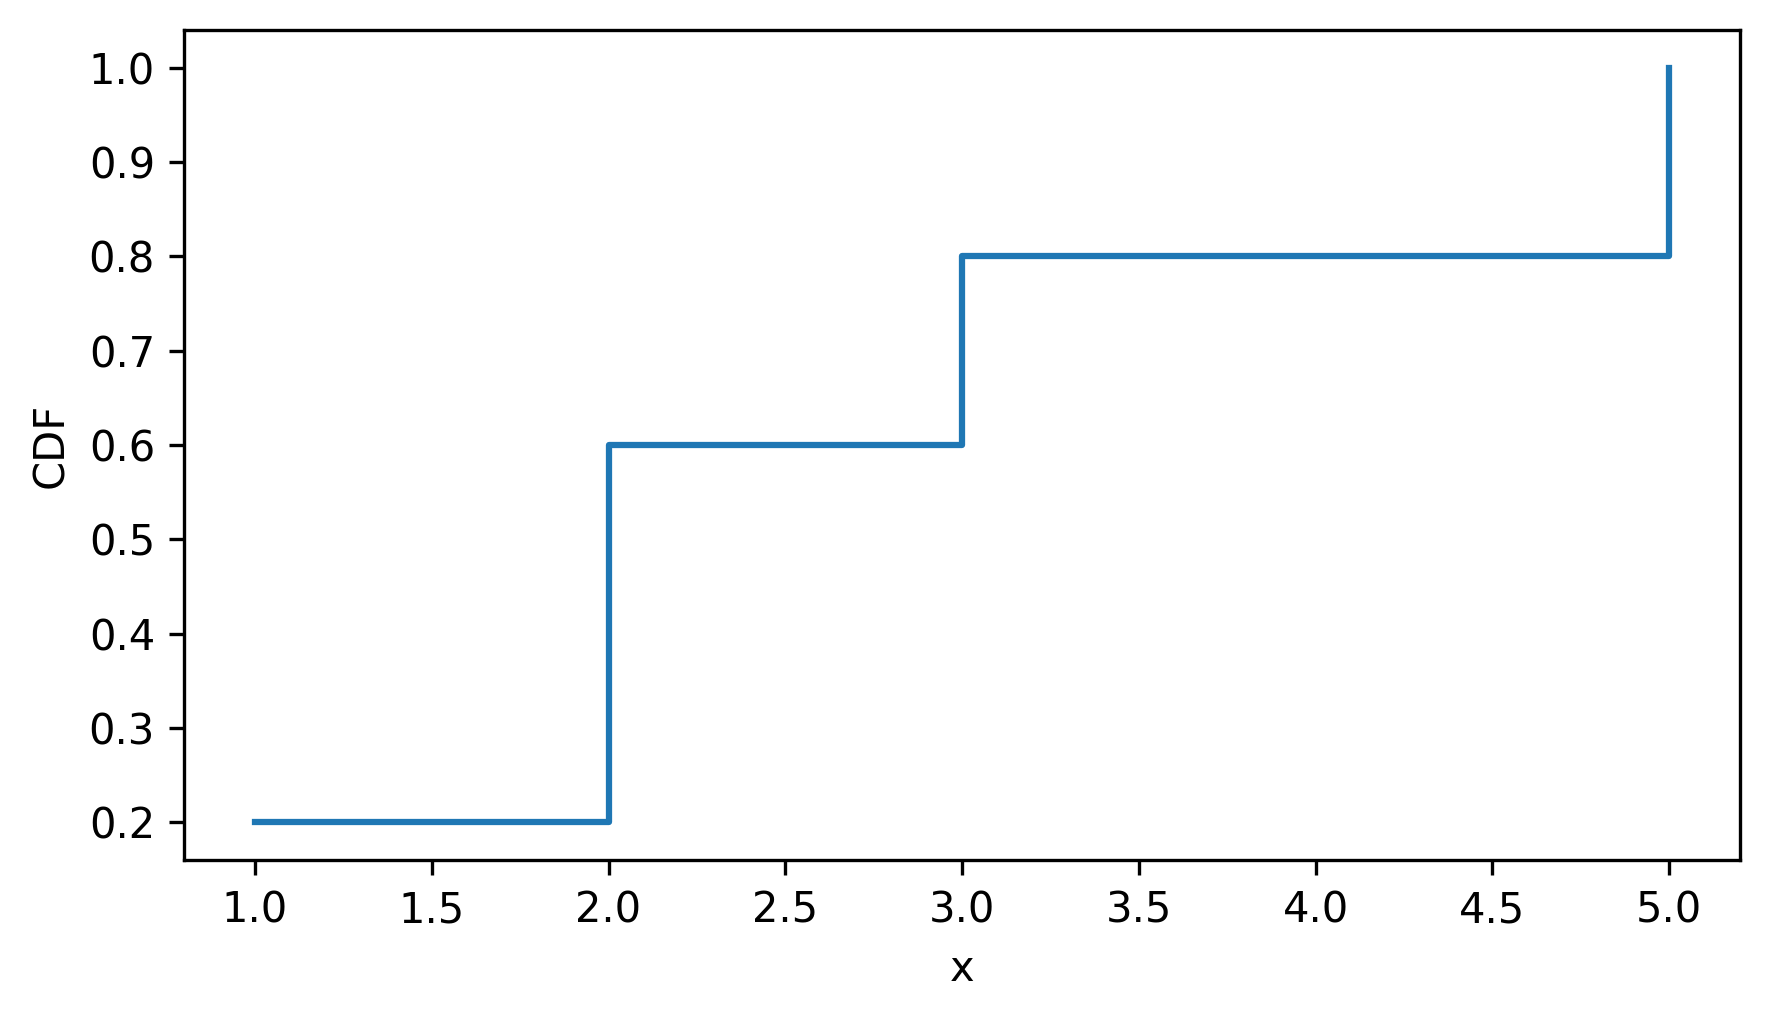

In [25]:
cdf.step()
decorate(xlabel="x", ylabel="CDF")

As a second example, let's make a `Cdf` that represents the distribution of running speeds from the previous section.
The `Cdf` class provides a `from_seq` function we can use to create a `Cdf` object from a sequence.

In [26]:
from empiricaldist import Cdf

cdf_speeds = Cdf.from_seq(speeds)

And here's what it looks like -- the vertical line is at my speed.

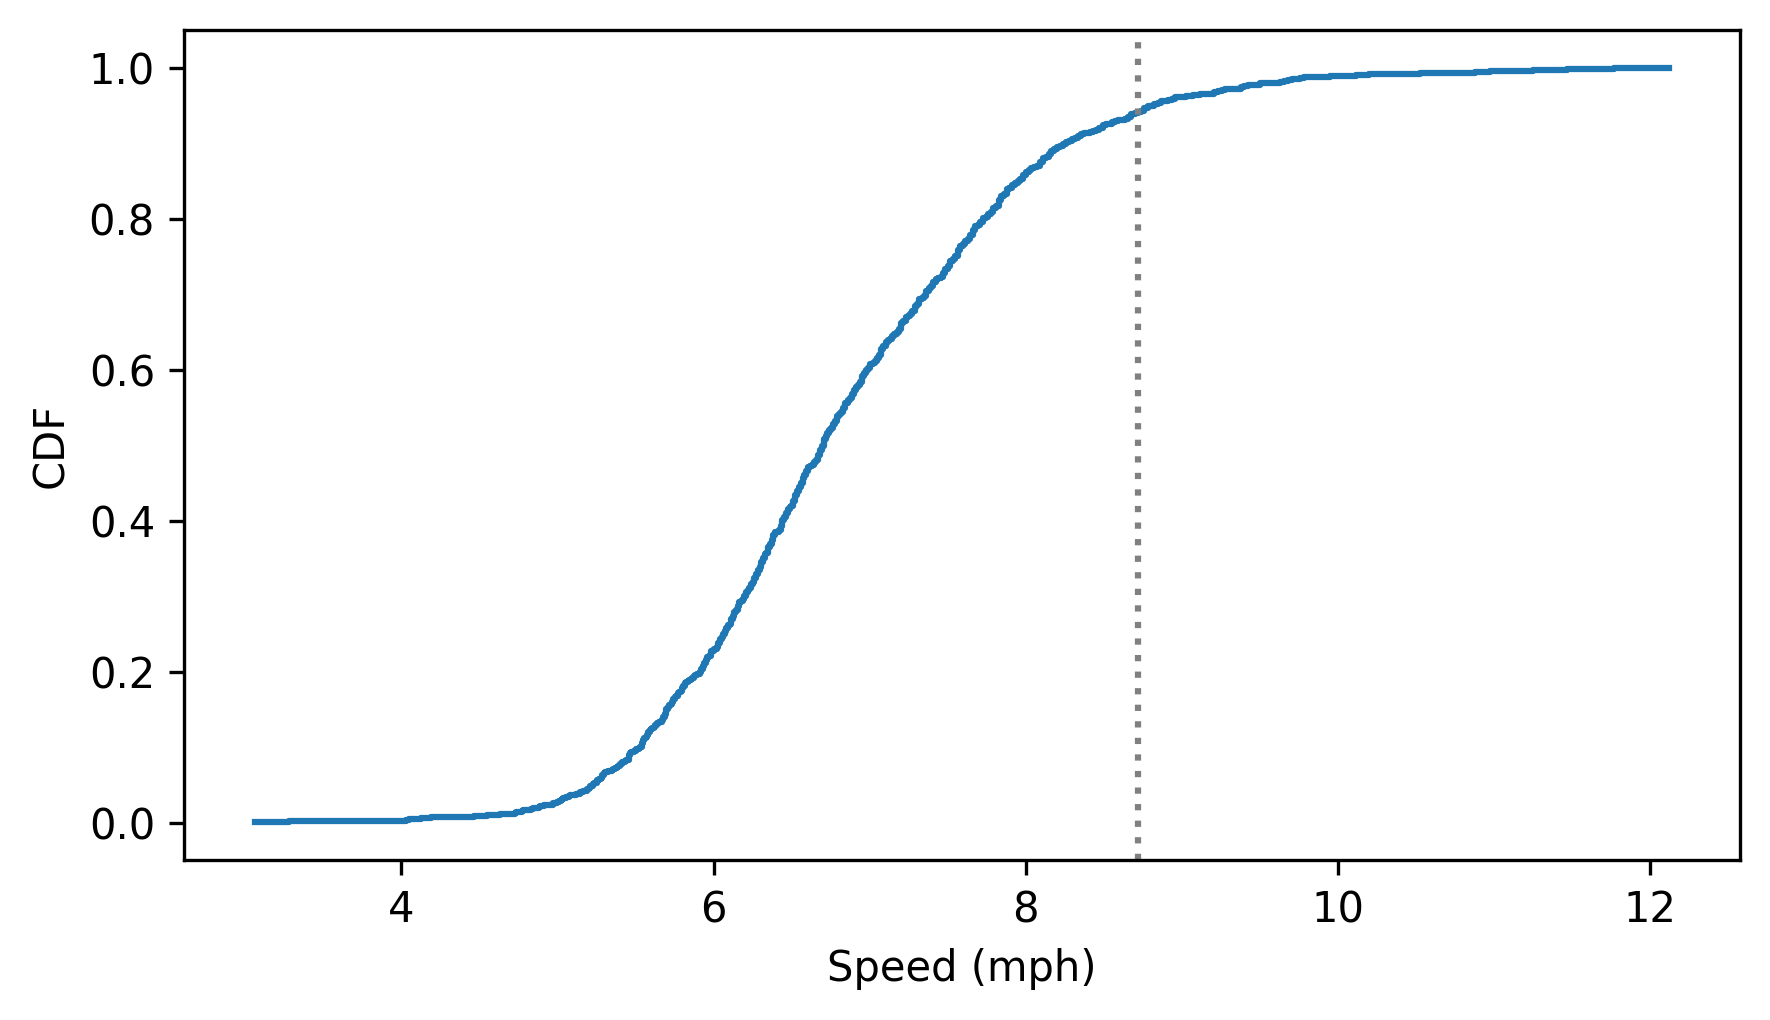

In [27]:
cdf_speeds.step()
plt.axvline(my_speed, ls=":", color="gray")
decorate(xlabel="Speed (mph)", ylabel="CDF")

If we look up my speed, the result is the fraction of runners at my speed or slower.
If we multiply by 100, we get my percentile rank.

In [28]:
cdf_speeds(my_speed) * 100

np.float64(94.12124923453766)

So that's one way to think about the `Cdf` -- given a value, it computes something like a percentile rank, except that it's a proportion between 0 and 1 rather than a percentage between 0 and 100.

`Cdf` provides an `inverse` method that computes the inverse of the cumulative distribution function -- given a proportion between 0 and 1, it finds the corresponding value.

For example, if someone says they ran as fast or faster than 50% of the field, we can find their speed like this.

In [29]:
cdf_speeds.inverse(0.5)

array(6.70391061)

If you have a proportion and you use the inverse CDF to find the corresponding value, the result is called a **quantile** -- so the inverse CDF is sometimes called the quantile function.

If you have have a quantile and you use the CDF to find the corresponding proportion, the result doesn't really have a name, strangely.
To be consistent with percentile and percentile rank, it could be called a "quantile rank", but as far as I can tell, no one calls it that.
Most often, it is just called a "cumulative probability".

(section_comparing_cdfs)=
## Comparing CDFs

CDFs are especially useful for comparing distributions.
As an example, let's compare the distribution of birth weights for first babies and others.
We'll load the NSFG dataset again, and divide it into three `DataFrames`: all live births, first babies, and others.

The following cells download the data files and install `statadict`, which we need to read the data.

In [30]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dat.gz")

Downloaded nsfg.py
Downloaded 2002FemPreg.dct
Downloaded 2002FemPreg.dat.gz


In [31]:
try:
    import statadict
except ImportError:
    %pip install statadict

In [32]:
from nsfg import get_nsfg_groups

live, firsts, others = get_nsfg_groups()

From `firsts` and `others` we'll select total birth weights in pounds, using `dropna` to remove values that are `nan`.

In [33]:
first_weights = firsts["totalwgt_lb"].dropna()
first_weights.mean()

np.float64(7.201094430437772)

In [34]:
other_weights = others["totalwgt_lb"].dropna()
other_weights.mean()

np.float64(7.325855614973262)

It looks like first babies are a little lighter on average.
But there are several ways a difference like that could happen -- for example, there might be a small number of first babies who are especially light, or a small number of other babies who are especially heavy.
In those cases, the distributions would have different shapes.
As another possibility, the distributions might have the same shape, but different locations.

To compare the distributions, we can try plotting the PMFs.

In [35]:
from empiricaldist import Pmf

first_pmf = Pmf.from_seq(first_weights, name="first")
other_pmf = Pmf.from_seq(other_weights, name="other")

But as we can see in the following figure, it doesn't work very well.

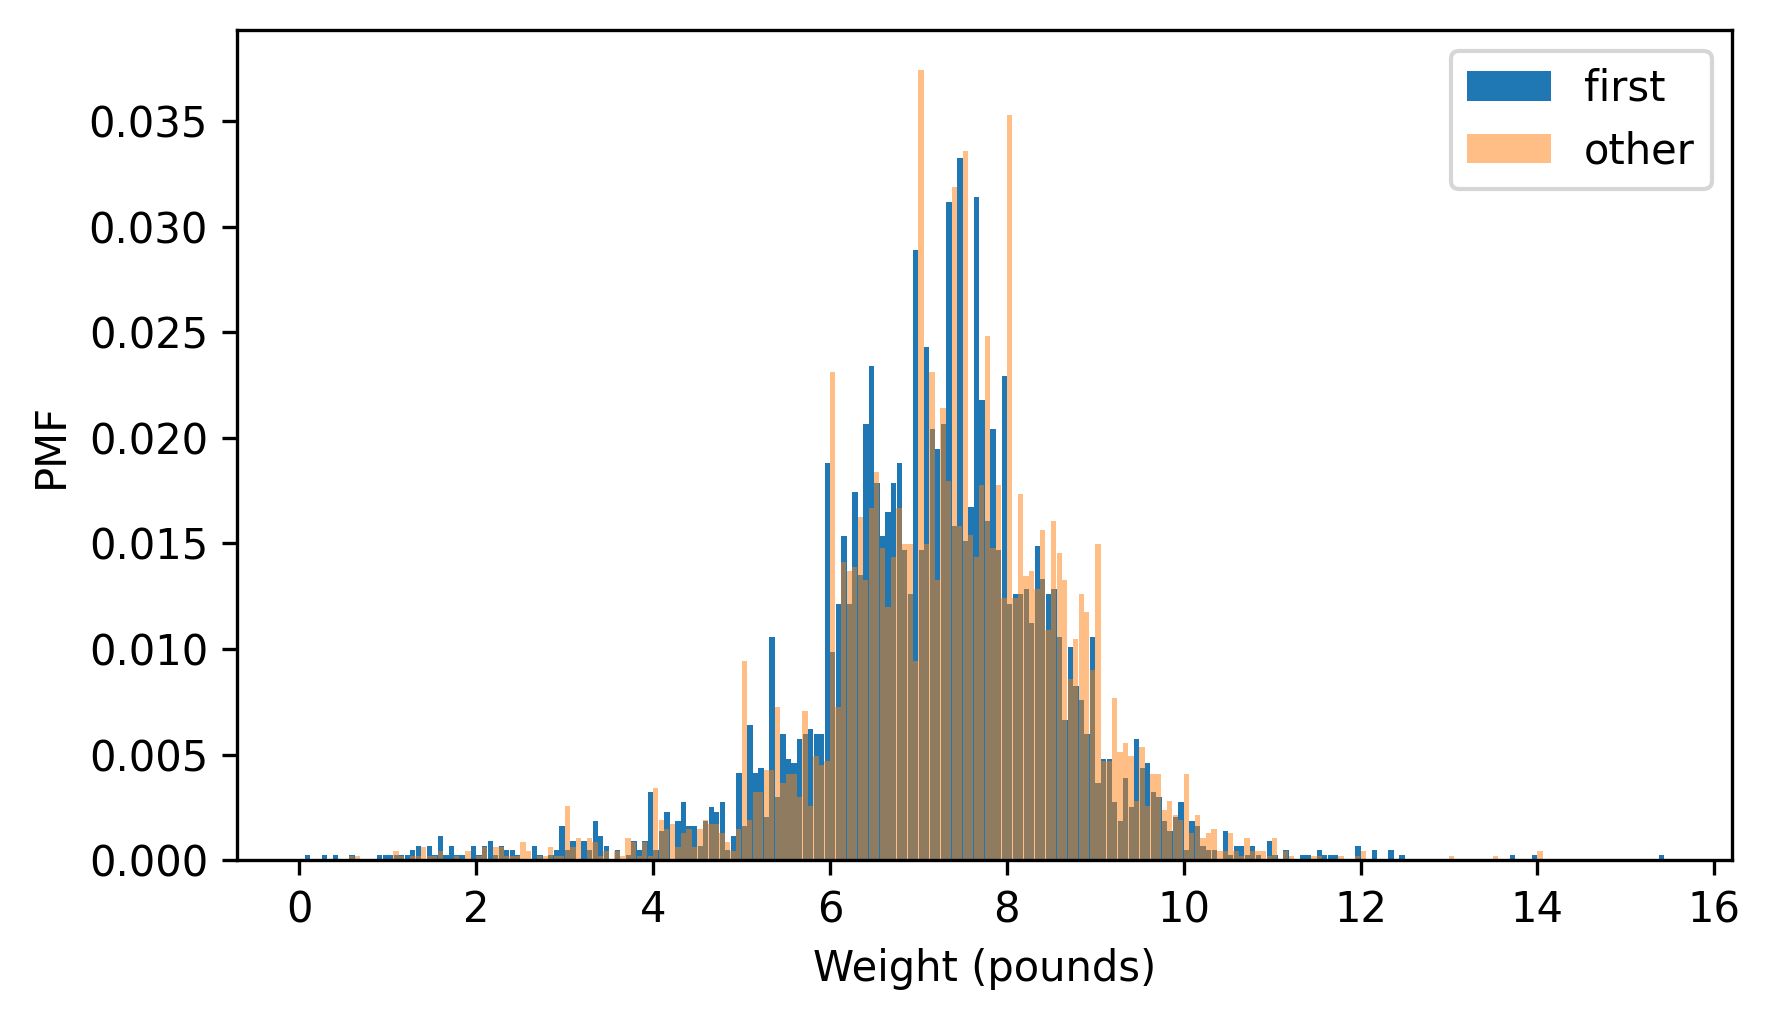

In [36]:
from thinkstats import two_bar_plots

two_bar_plots(first_pmf, other_pmf, width=0.06)
decorate(xlabel="Weight (pounds)", ylabel="PMF")

I adjusted the width and transparency of the bars to show the distributions as clearly as possible, but it is hard to compare them.
There are many peaks and valleys, and some apparent differences, but it is hard to tell which of these features are meaningful.
Also, it is hard to see overall patterns; for example, it is not visually apparent which distribution has the higher mean.

These problems can be mitigated by binning the data -- that is, dividing the range of quantities into non-overlapping intervals and counting the number of quantities in each bin.
Binning can be useful, but it is tricky to get the size of the bins right.
If they are big enough to smooth out noise, they might also smooth out useful information.

A good alternative is to plot the CDFs.

In [37]:
first_cdf = first_pmf.make_cdf()
other_cdf = other_pmf.make_cdf()

Here's what they look like.

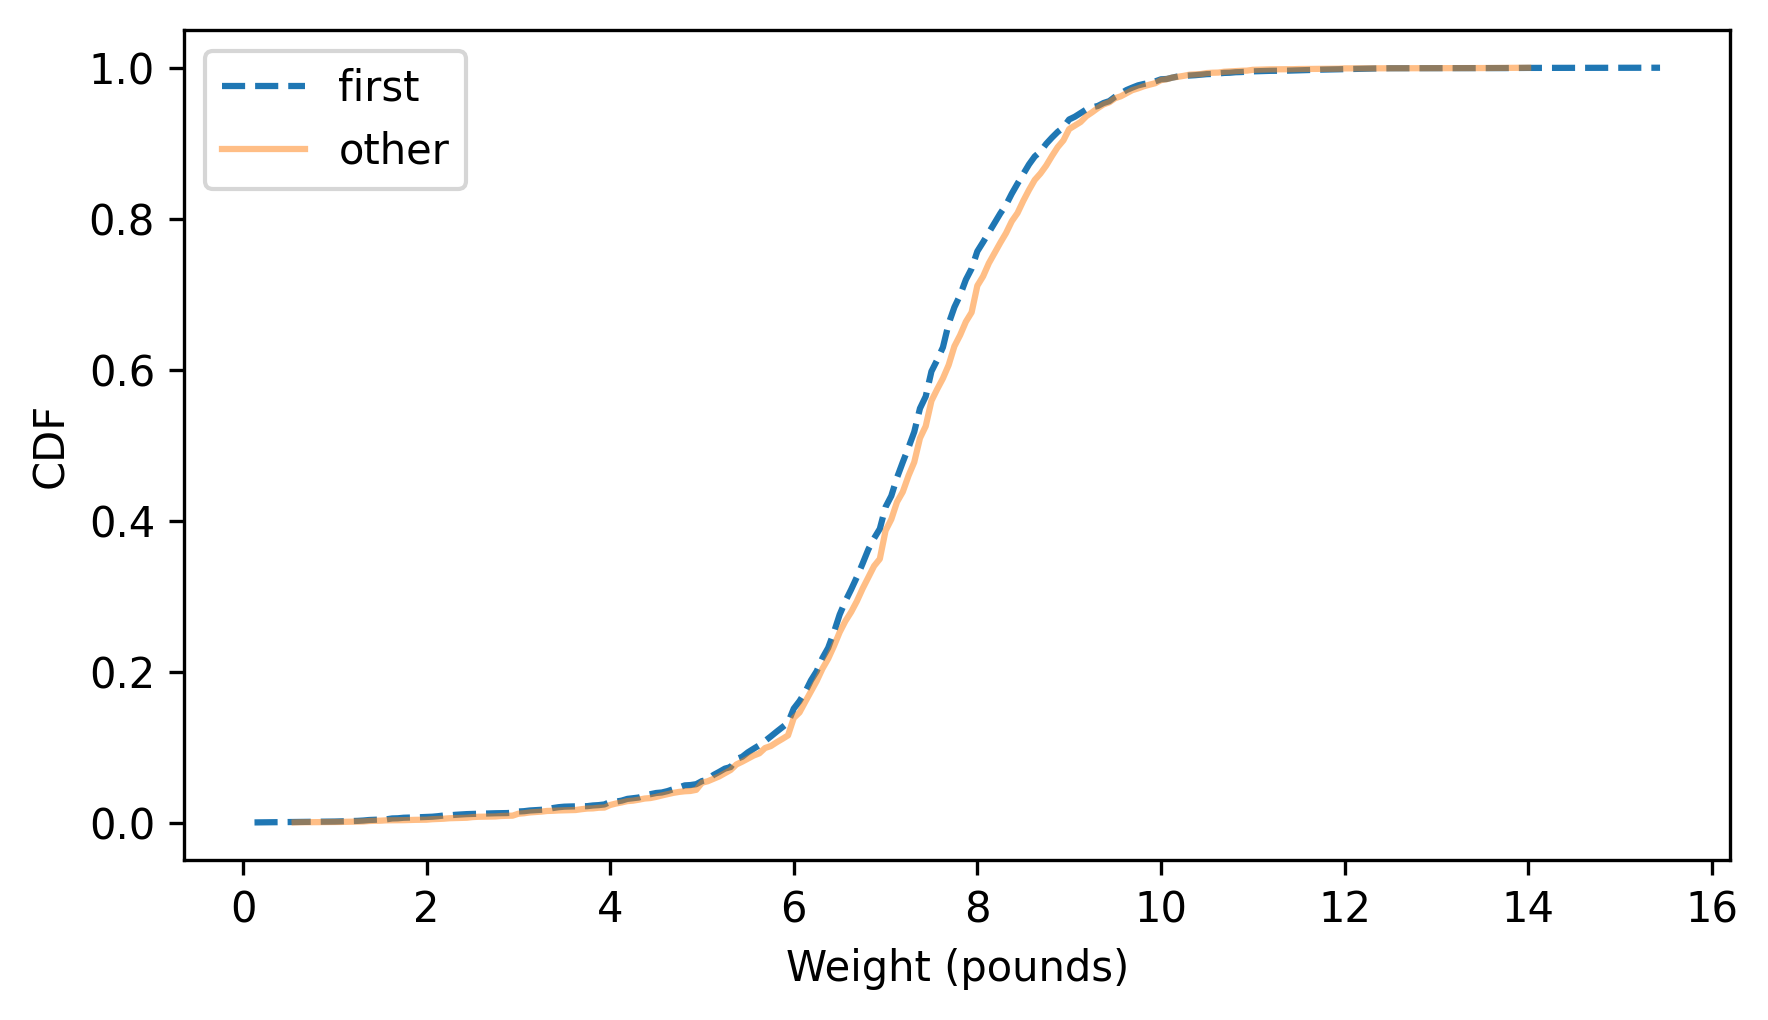

In [38]:
first_cdf.plot(ls="--")
other_cdf.plot(alpha=0.5)
decorate(xlabel="Weight (pounds)", ylabel="CDF")

This figure makes the shape of the distributions, and the differences between them, much clearer.
The curve for first babies is consistently to the left of the curve for others, which indicates that first babies are slightly lighter throughout the distribution -- with a larger discrepancy above the midpoint.

## Percentile-Based Statistics

In [Chapter 3](section_summarizing_pmfs) we computed the arithmetic mean, which identifies a central point in a distribution, and the standard deviation, which quantifies how spread out the distribution is.
And in a previous exercise we computed skewness, which indicates whether a distribution is skewed left or right.
One drawback of all of these statistics is that they are sensitive to outliers.
A single extreme value in a dataset can have a large effect on mean, standard deviation, and skewness.

An alternative is to use statistics that are based on percentiles of the distribution, which tend to be more **robust**, which means that they are less sensitive to outliers.
To demonstrate, let's load the NSFG data again without doing any data cleaning.

In [39]:
from nsfg import read_stata

dct_file = "2002FemPreg.dct"
dat_file = "2002FemPreg.dat.gz"

preg = read_stata(dct_file, dat_file)

Recall that birth weight is recorded in two columns, one for the pounds and one for the ounces.

In [40]:
birthwgt_lb = preg["birthwgt_lb"]
birthwgt_oz = preg["birthwgt_oz"]

If we make a `Hist` object with the values from `birthwgt_oz`, we can see that they include the special values 97, 98, and 99, which indicate missing data.

In [41]:
from empiricaldist import Hist

Hist.from_seq(birthwgt_oz).tail(5)

,
birthwgt_oz,
14.0,475
15.0,378
97.0,1
98.0,1
99.0,46


The `birthwgt_lb` column includes the same special values; it also includes the value 51, which has to be a mistake.

In [42]:
Hist.from_seq(birthwgt_lb).tail(5)

,
birthwgt_lb,
15.0,1
51.0,1
97.0,1
98.0,1
99.0,57


Now let's imagine two scenarios.
In one scenario, we clean these variables by replacing missing and invalid values with `nan`, and then compute total weight in pounds.
Dividing `birthwgt_oz_clean` by 16 converts it to pounds in decimal.

In [43]:
birthwgt_lb_clean = birthwgt_lb.replace([51, 97, 98, 99], np.nan)
birthwgt_oz_clean = birthwgt_oz.replace([97, 98, 99], np.nan)

total_weight_clean = birthwgt_lb_clean + birthwgt_oz_clean / 16

In the other scenario, we neglect to clean the data and accidentally compute the total weight with these bogus values.

In [44]:
total_weight_bogus = birthwgt_lb + birthwgt_oz / 16

The bogus dataset contains only 49 bogus values, which is about 0.5% of the data.

In [45]:
count1, count2 = total_weight_bogus.count(), total_weight_clean.count()
diff = count1 - count2

diff, diff / count2 * 100

(np.int64(49), np.float64(0.5421553441026776))

Now let's compute the mean of the data in both scenarios.

In [46]:
mean1, mean2 = total_weight_bogus.mean(), total_weight_clean.mean()
mean1, mean2

(np.float64(7.319680587652691), np.float64(7.265628457623368))

The bogus values have a moderate effect on the mean.
If we take the mean of the cleaned data to be correct, the mean of the bogus data is off by less than 1%.

In [47]:
(mean1 - mean2) / mean2 * 100

np.float64(0.74394294099376)

An error like that might go undetected -- but now let's see what happens to the standard deviations.

In [48]:
std1, std2 = total_weight_bogus.std(), total_weight_clean.std()
std1, std2

(2.0960017791618313, 1.4082934455690168)

In [49]:
(std1 - std2) / std2 * 100

48.832744039005874

The standard deviation of the bogus data is off by almost 50%, so that's more noticeable.
Finally, here's the skewness of the two datasets.

In [50]:
def skewness(seq):
    """Compute the skewness of a sequence

    seq: sequence of numbers

    returns: float skewness
    """
    deviations = seq - seq.mean()
    return np.mean(deviations**3) / seq.std(ddof=0) ** 3

In [51]:
skew1, skew2 = skewness(total_weight_bogus), skewness(total_weight_clean)
skew1, skew2

(np.float64(22.251846195422598), np.float64(-0.5895062687577703))

In [52]:
# how much is skew1 off by?
(skew1 - skew2) / skew2

np.float64(-38.74658112171143)

The skewness of the bogus dataset is off by a factor of almost 40, and it has the wrong sign! With the outliers added to the data, the distribution is strongly skewed to the right, as indicated by large positive skewness.
But the distribution of the valid data is slightly skewed to the left, as indicated by small negative skewness.

These results show that a small number of outliers have a moderate effect on the mean, a strong effect on the standard deviation, and a disastrous effect on skewness.

An alternative is to use statistics based on percentiles.
Specifically:

* The median, which is the 50th percentile, identifies a central point in a distribution, like the mean.

* The interquartile range, which is the difference between the 25th and 75th percentiles, quantifies the spread of the distribution, like the standard deviation.

* The quartile skewness uses the quartiles of the distribution (25th, 50th, and 75th percentiles) to quantify the skewness.

The `Cdf` object provides an efficient way to compute these percentile-based statistics.
To demonstrate, let's make a `Cdf` object from the bogus and clean datasets.

In [53]:
cdf_total_weight_bogus = Cdf.from_seq(total_weight_bogus)
cdf_total_weight_clean = Cdf.from_seq(total_weight_clean)

The following function takes a `Cdf` and uses its `inverse` method to compute the 50th percentile, which is the median (at least, it is one way to define the median of a dataset).

In [54]:
def median(cdf):
    m = cdf.inverse(0.5)
    return m

Now we can compute the median of both datasets.

In [55]:
median(cdf_total_weight_bogus), median(cdf_total_weight_clean)

(array(7.375), array(7.375))

The results are identical, so in this case, the outliers have no effect on the median at all.
In general, outliers have a smaller effect on the median than on the mean.

The **interquartile range** (IQR) is the difference between the 75th and 25th percentiles.
The following function takes a `Cdf` and returns the IQR.

In [56]:
def iqr(cdf):
    low, high = cdf.inverse([0.25, 0.75])
    return high - low

And here are the interquartile ranges of the two datasets.

In [57]:
iqr(cdf_total_weight_bogus), iqr(cdf_total_weight_clean)

(np.float64(1.625), np.float64(1.625))

In general, outliers have less effect on the IQR than on the standard deviation -- in this case they have no effect at all.

Finally, here's a function that computes quartile skewness, which depends on three statistics:

* The median,

* The midpoint of 25th and 75th percentiles, and

* The semi-IQR, which is half of the IQR.

In [58]:
def quartile_skewness(cdf):
    low, median, high = cdf.inverse([0.25, 0.5, 0.75])
    midpoint = (high + low) / 2
    semi_iqr = (high - low) / 2
    return (midpoint - median) / semi_iqr

And here's the quartile skewness for the two datasets.

In [59]:
qskew1 = quartile_skewness(cdf_total_weight_bogus)
qskew2 = quartile_skewness(cdf_total_weight_clean)
qskew1, qskew2

(np.float64(-0.07692307692307693), np.float64(-0.07692307692307693))

The small number of outliers in these examples has no effect on the quartile skewness.
These examples show that percentile-based statistics are less sensitive to outliers and errors in the data.

## Random Numbers

`Cdf` objects provide an efficient way to generate random numbers from a distribution.
First we generate random numbers from a uniform distribution between 0 and 1.
Then we evaluate the inverse CDF at those points.
The following function implements this algorithm.

In [60]:
def sample_from_cdf(cdf, n):
    ps = np.random.random(size=n)
    return cdf.inverse(ps)

To demonstrate, let's generate a random sample of running speeds.

In [61]:
sample = sample_from_cdf(cdf_speeds, 1001)

To confirm that it worked, we can compare the CDFs of the sample and the original dataset.

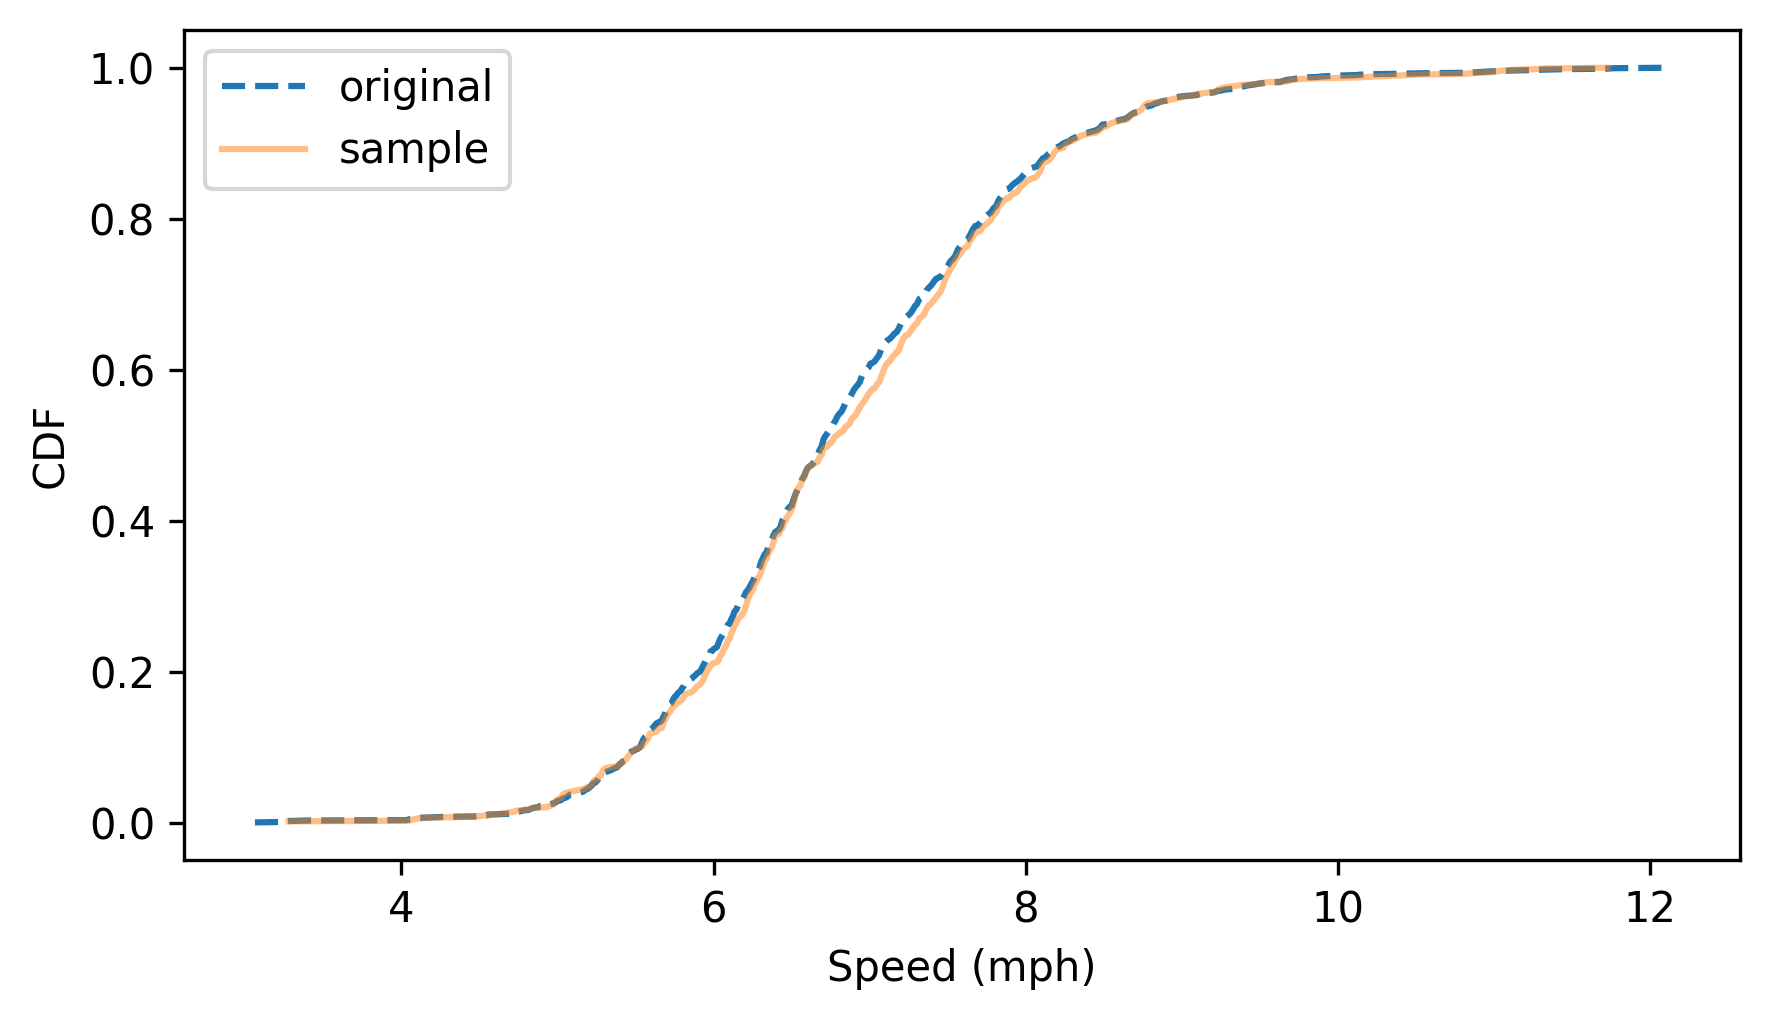

In [62]:
cdf_sample = Cdf.from_seq(sample)

cdf_speeds.plot(label="original", ls="--")
cdf_sample.plot(label="sample", alpha=0.5)

decorate(xlabel="Speed (mph)", ylabel="CDF")

The sample follows the distribution of the original data.
To understand how this algorithm works, consider this question:
Suppose we choose a random sample from the population of running speeds and look up the percentile ranks of the speeds in the sample.
Now suppose we compute the CDF of the percentile ranks.
What do you think it will look like?

Let's find out. Here are the percentile ranks for the sample we generated.

In [63]:
percentile_ranks = cdf_speeds(sample) * 100

And here is the CDF of the percentile ranks.

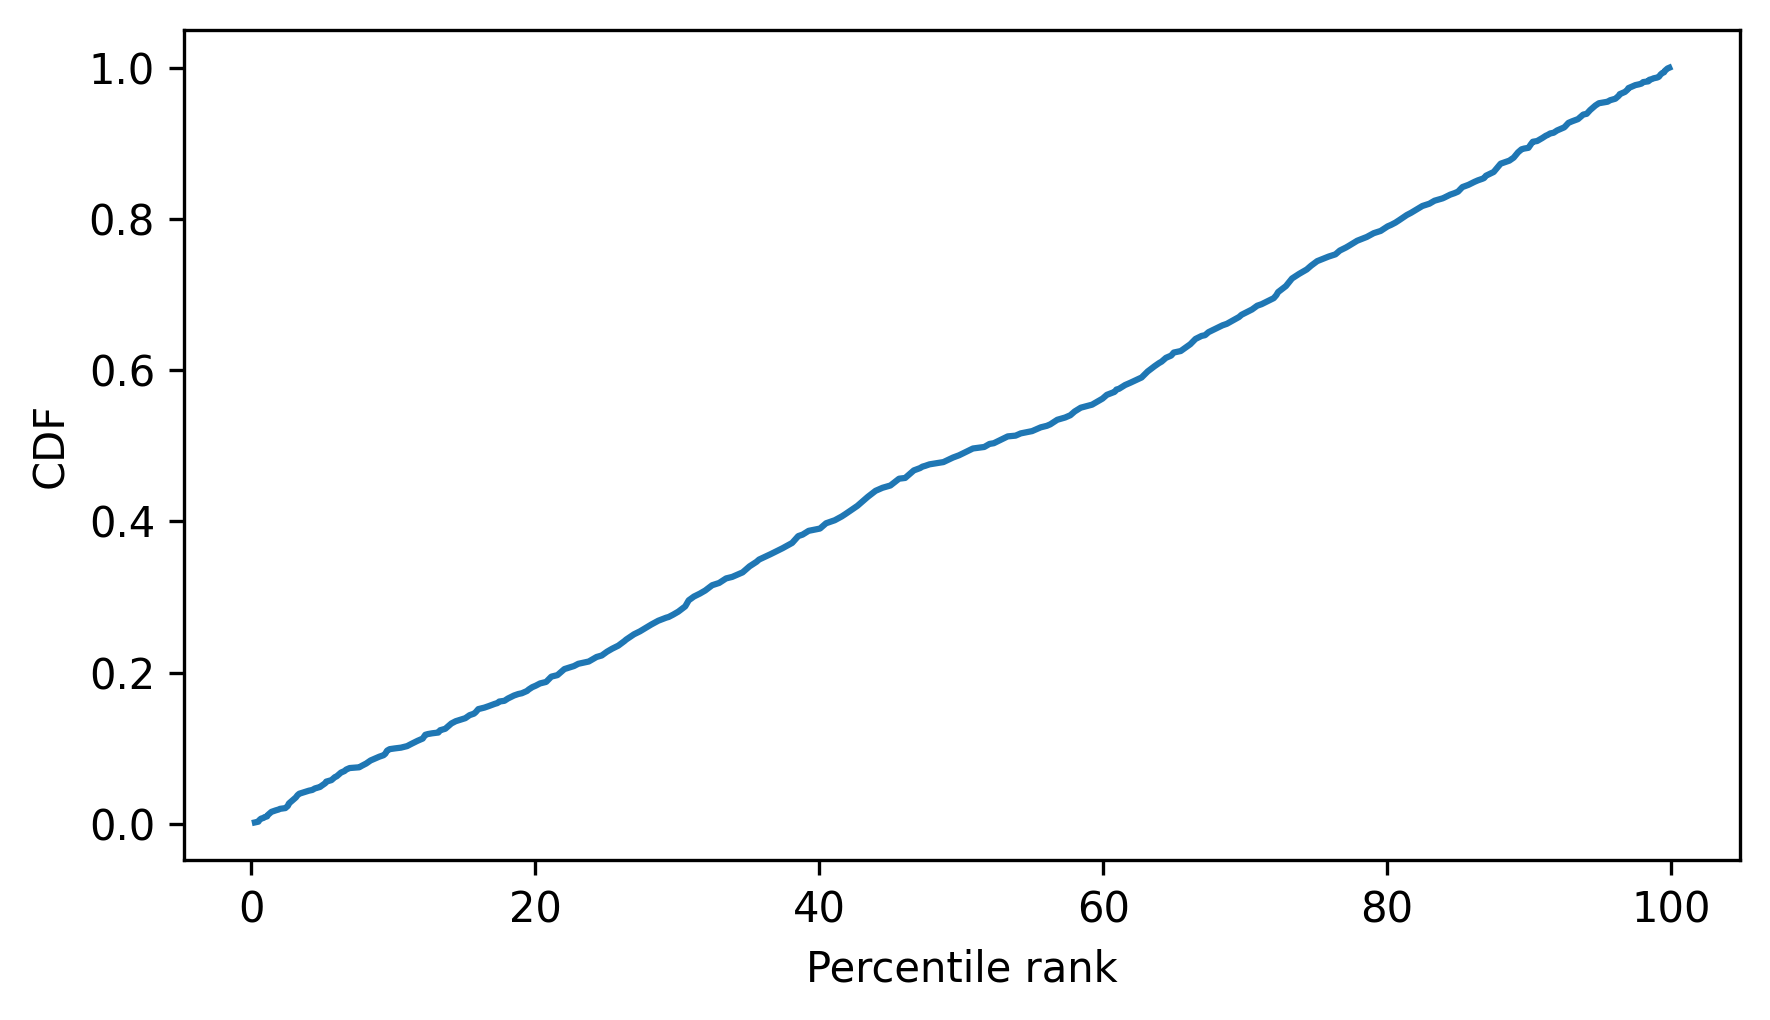

In [64]:
cdf_percentile_rank = Cdf.from_seq(percentile_ranks)
cdf_percentile_rank.plot()

decorate(xlabel="Percentile rank", ylabel="CDF")

The CDF of the percentile ranks is close to a straight line between 0 and 1.
And that makes sense, because in any distribution, the proportion with percentile rank less than 50% is 0.5; the proportion with percentile rank less than 90% is 0.9, and so on.

`Cdf` provides a `sample` method that uses this algorithm, so we could also generate a sample like this.

In [65]:
sample = cdf_speeds.sample(1001)

## Glossary

-   **percentile rank**: The percentage of values in a distribution that are less than or equal to a given quantity.

-   **percentile**: The value in a distribution associated with a given percentile rank.

-   **cumulative distribution function (CDF)**: A function that maps a value to the proportion of the distribution less than or equal to that value.

-   **quantile**: The value in a distribution that is greater than or equal to a given proportion of values.

-   **robust**: A statistic is robust if it is less affected by extreme values or outliers.

-   **interquartile range (IQR)**: The difference between the 75th and 25th percentiles, used to measure the spread of a distribution.

## Exercises

### Exercise 4.1

How much did you weigh at birth?
If you don't know, call your mother or someone else who knows.
And if no one knows, you can use my birth weight, 8.5 pounds, for this exercise.

Using the NSFG data (all live births), compute the distribution of birth weights and use it to find your percentile rank.
If you were a first baby, find your percentile rank in the distribution for first babies.
Otherwise use the distribution for others.
If you are in the 90th percentile or higher, call your mother back and apologize.

In [88]:
from nsfg import get_nsfg_groups

live, firsts, others = get_nsfg_groups()
first_weights = firsts["totalwgt_lb"].dropna()
first_weights.head()

,totalwgt_lb
0,8.8125
2,9.1250
5,8.5625
8,7.5625
10,7.8125


<Axes: xlabel='totalwgt_lb'>

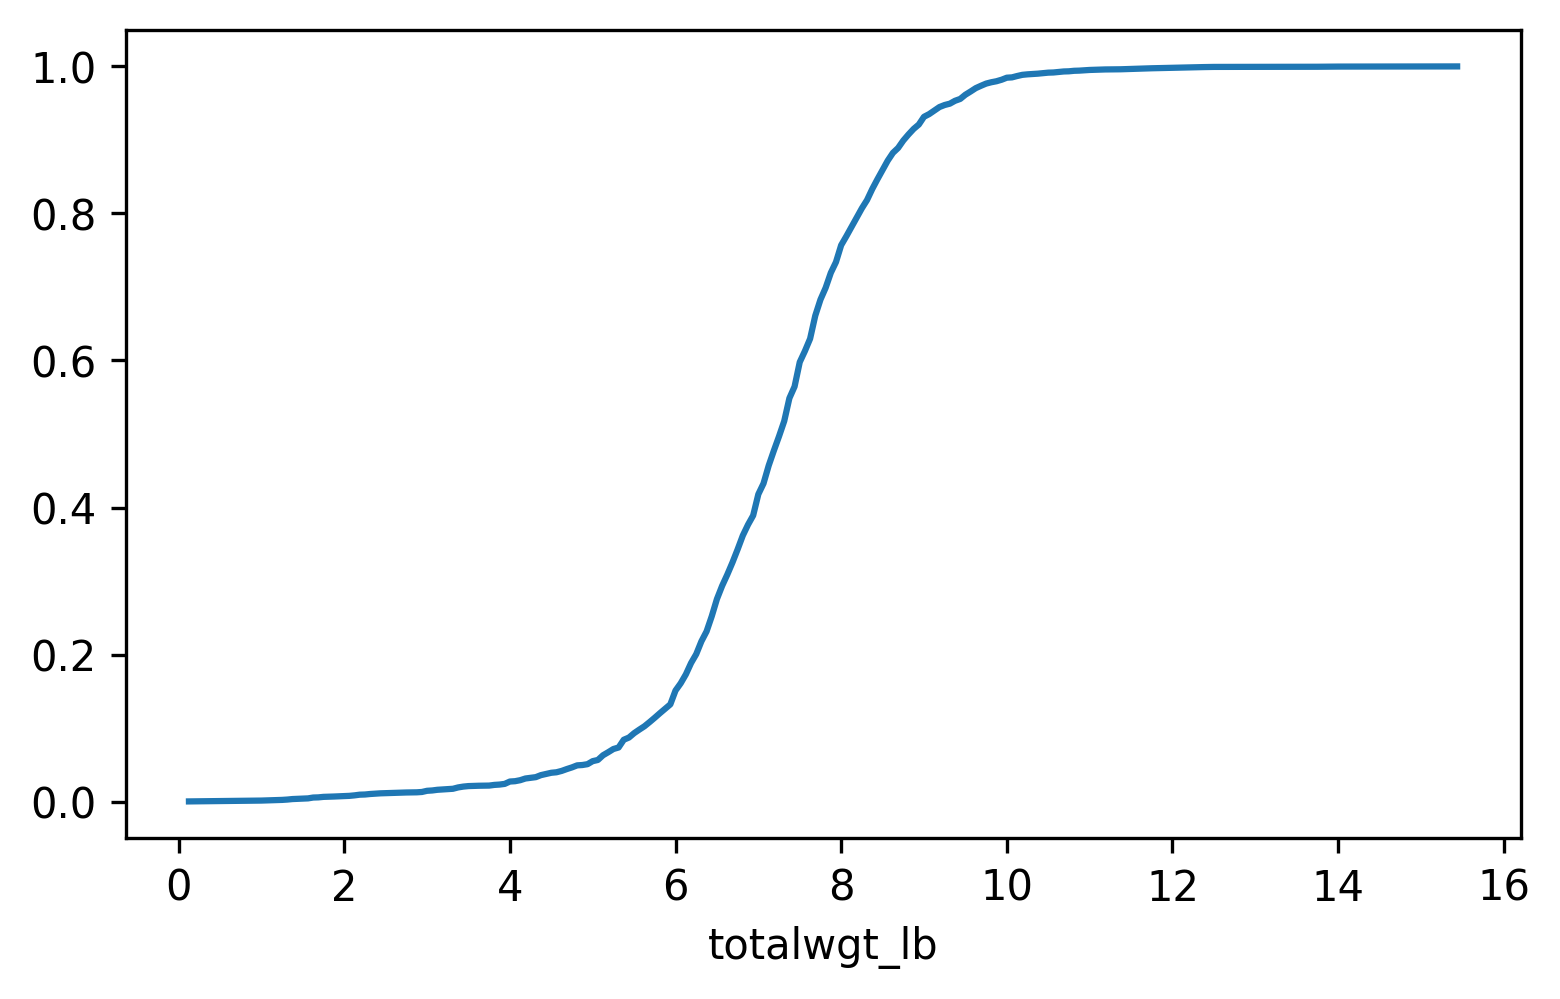

In [89]:
# Solution goes here
cdf_percentile_rank = Cdf.from_seq(first_weights)
cdf_percentile_rank.plot()

In [103]:
# Solution goes here
percentile_rank(8.9, first_weights)


np.float64(91.49667659867063)

In [104]:
# Solution goes here

### Exercise 4.2

For live births in the NSFG dataset, the column `babysex` indicates whether the baby was male or female.
We can use `query` to select the rows for male and female babies.

In [105]:
male = live.query("babysex == 1")
female = live.query("babysex == 2")
len(male), len(female)

(4641, 4500)

In [108]:
male.head()

,caseid,pregordr,howpreg_n,howpreg_p,moscurrp,nowprgdk,pregend1,pregend2,nbrnaliv,multbrth,...,laborfor_i,religion_i,metro_i,basewgt,adj_mod_basewgt,finalwgt,secu_p,sest,cmintvw,totalwgt_lb
0,1,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,1231,8.8125
2,2,1,NaN,NaN,NaN,NaN,5.0,NaN,3.0,5.0,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,1231,9.1250
5,6,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,4870.926435,5325.196999,8874.440799,1,23,1231,8.5625
8,7,1,NaN,NaN,NaN,NaN,5.0,NaN,1.0,NaN,...,0,0,0,3409.579565,3787.539000,6911.879921,2,14,1233,7.5625
10,12,1,NaN,NaN,NaN,NaN,5.0,NaN,1.0,NaN,...,0,0,0,3612.781968,4146.013572,6909.331618,1,31,1231,7.8125


Make `Cdf` objects that represent the distribution of birth weights for male and female babies.
Plot the two CDFs.
What are the differences in the shape and location of the distributions?

If a male baby weighs 8.5 pounds, what is his percentile rank? What is the weight of a female baby with the same percentile rank?

In [117]:
# Solution goes here
cdf_male = Cdf.from_seq(male['totalwgt_lb'])
cdf_female = Cdf.from_seq(female['totalwgt_lb'])

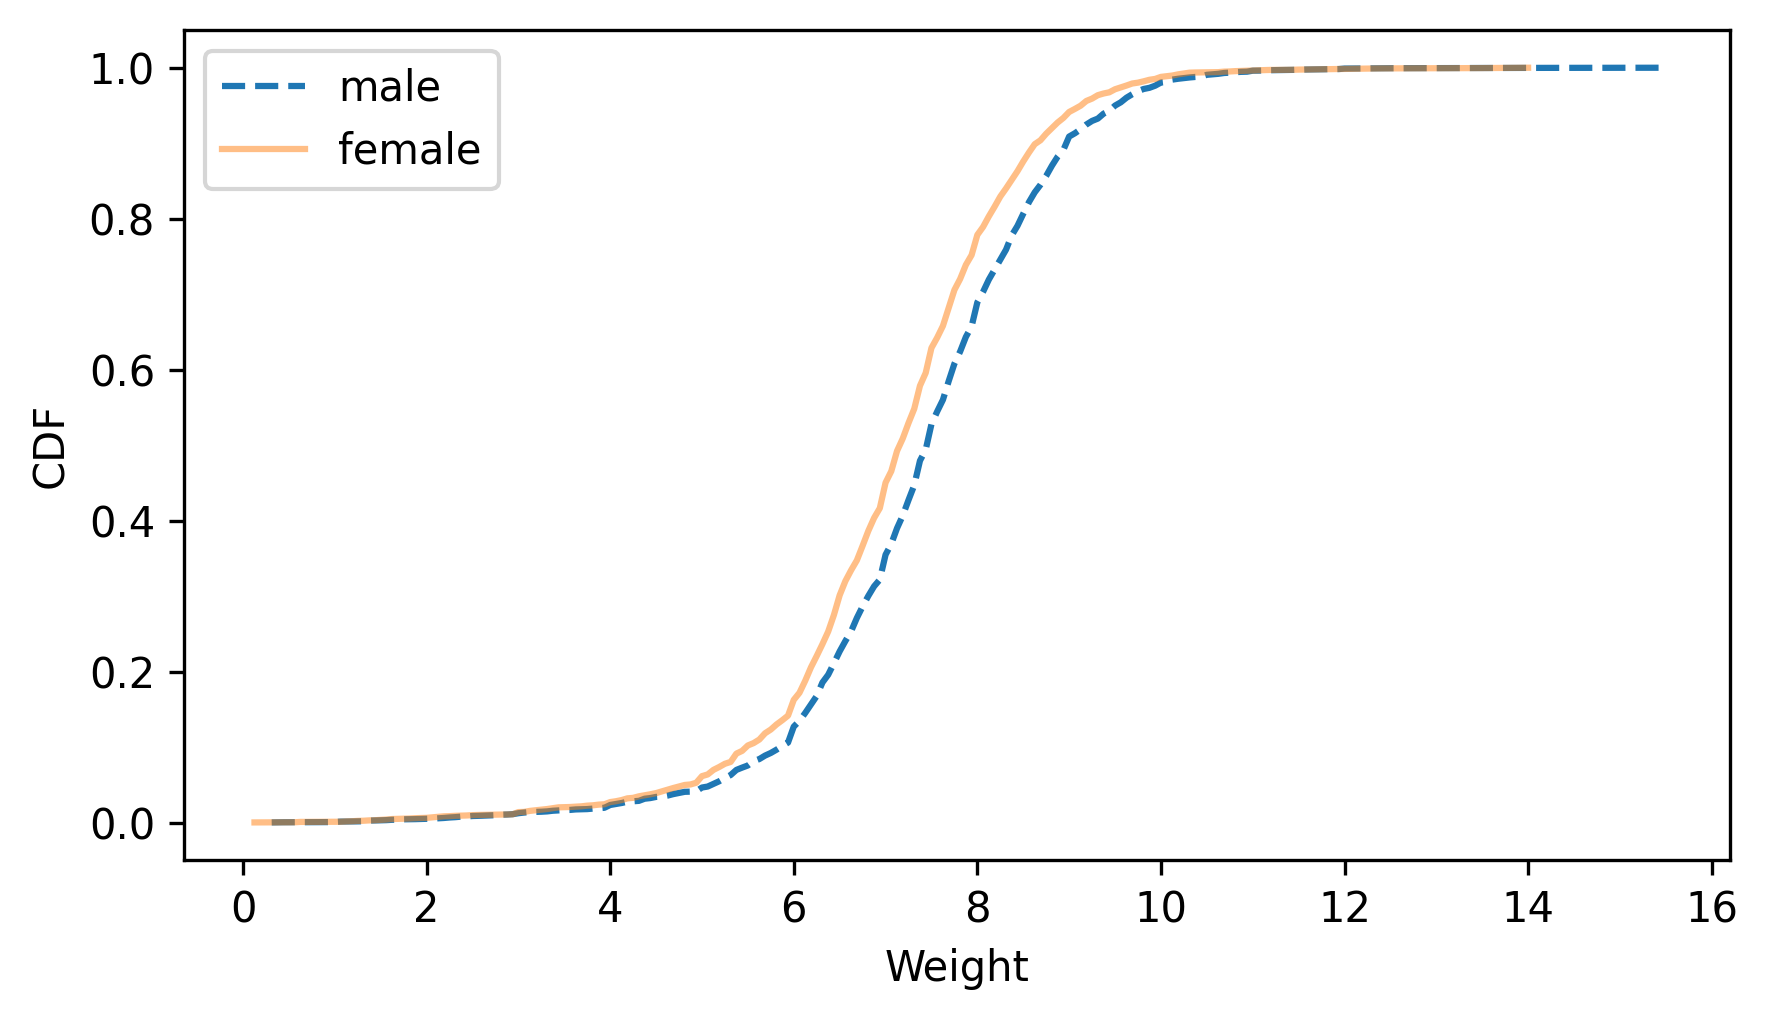

In [110]:
# Solution goes here
cdf_male.plot(label="male", ls="--")
cdf_female.plot(label="female", alpha=0.5)

decorate(xlabel="Weight", ylabel="CDF")

In [113]:
# Solution goes here
percentile_rank(8.5, male['totalwgt_lb'])

np.float64(79.68110321051498)

In [118]:
# Solution goes here
male_perc_rank = percentile_rank(8.5, male['totalwgt_lb'])
percentile(male_perc_rank, female['totalwgt_lb'].values)

np.float64(7.0625)

In [75]:
# Solution goes here

### Exercise 4.3

From the NSFG dataset pregnancy data, select the `agepreg` column and make a `Cdf` to represent the distribution of age at conception for each pregnancy.
Use the CDF to compute the percentage of ages less than or equal to 20, and the percentage less than or equal to 30.
Use those results to compute the percentage between 20 and 30.

In [120]:
from nsfg import read_fem_preg

preg = read_fem_preg()
preg.head()

,caseid,pregordr,howpreg_n,howpreg_p,moscurrp,nowprgdk,pregend1,pregend2,nbrnaliv,multbrth,...,laborfor_i,religion_i,metro_i,basewgt,adj_mod_basewgt,finalwgt,secu_p,sest,cmintvw,totalwgt_lb
0,1,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,1231,8.8125
1,1,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,3410.389399,3869.349602,6448.271112,2,9,1231,7.8750
2,2,1,NaN,NaN,NaN,NaN,5.0,NaN,3.0,5.0,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,1231,9.1250
3,2,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,1231,7.0000
4,2,3,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,0,0,7226.301740,8567.549110,12999.542264,2,12,1231,6.1875


In [121]:
# Solution goes here
cdf_age = Cdf.from_seq(preg['agepreg'])
cdf_age

,
agepreg,
10.33,0.000076
10.50,0.000151
10.83,0.000227
10.91,0.000302
11.08,0.000378
...,...
43.16,0.999320
43.25,0.999622
43.58,0.999849


In [128]:
# Solution goes here
print(f"<= 20 : ",cdf_age[20]*100)
print(f"<= 30 : ",cdf_age[30]*100)

<= 20 :  24.718676837096893
<= 30 :  80.46220074012537


In [129]:
# Solution goes here
print(f"percentage between 20 and 30 : ", (cdf_age[30]*100) - (cdf_age[20]*100))

percentage between 20 and 30 :  55.743523903028475


In [80]:
# Solution goes here

### Exercise 4.4

Here are the running speeds of the people who finished the James Joyce Ramble, described earlier in this chapter.

In [81]:
speeds = results["MPH"].values

Make a `Cdf` that represents the distribution of these speeds, and use it to compute the median, IQR, and quartile skewness.
Does the distribution skew to the left or right?

In [82]:
# Solution goes here

In [83]:
# Solution goes here

### Exercise 4.5

The numbers generated by `np.random.random` are supposed to be uniform between 0 and 1, which means that the CDF of a sample should be a straight line.
Let's see if that's true.
Here's a sample of 1001 numbers. Plot the CDF of this sample. Does it look like a straight line?

In [84]:
t = np.random.random(1001)

In [85]:
# Solution goes here

In [86]:
# Solution goes here

[Think Stats: Exploratory Data Analysis in Python, 3rd Edition](https://allendowney.github.io/ThinkStats/index.html)

Copyright 2024 [Allen B. Downey](https://allendowney.com)

Code license: [MIT License](https://mit-license.org/)

Text license: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)